In [ ]:
DBFILE = "dell-crux-temp.db"
NAME_PREFIX="TEMP-DELETE"

# analyze `____.db` data

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks-....db` database (created by `blocksDB_create.py`) containing all the blocks.

---

### Interactive version!
This notebook here allows to interactively manipulate the diagrams, etc. However:
The same output diagrams can also be created by calling on the commandline e.g.:

```
./blocksDB_diagramming.py temp.db prefix
```
for the whole chain, or e.g. 
```
./blocksDB_diagramming.py temp.db prefix 115 230
```
for just those blocks 115-230

### TODO
Now that **all** subroutines are refactored into `blocksDB_diagramming.py`, clean them out of here, and instead import them. See `def load_prepare_plot_save(...)` in `blocksDB_diagramming.py`.


Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, London 2018  
> https://github.com/drandreaskrueger/chainhammer

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


<a id='TOC'>table of contents</a>

## TOC

Code 

* [dependencies & my own routines](#dependencies)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* [tables of peak TPS rates](#tables)
* [whole chain](#allblocks)
* [zooming in](#zoom)



<a id='dependencies'>load dependencies</a>

In [ ]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

# my own routines are now all in separate .py file:
from blocksDB_diagramming import DB_query, DB_tableSize, maxBlockNumber, check_whether_complete
from blocksDB_diagramming import add_blocktime, add_TPS, add_GUPS, add_GLPS

print ("\nReading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 0.23.4
numpy version 1.15.2
matplotlib version 3.0.0

Reading blocks table from dell-crux-temp.db


<a id='stats'>simple statistics</a>
### some simple statistics

In [ ]:
# open database connection
conn = sqlite3.connect(DBFILE)

print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?
minblock, maxblock = maxBlockNumber(conn)[0]

blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

# do we have consecutive blocks, none missing?
check_whether_complete(blocknumbers)

DB table names:  ('blocks',)
TABLE blocks has 354 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 353)] 
len(blocknumbers)= 354

complete between blocks 0 and 353.


In [ ]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 51549
txcount_max 367
txcount_av 56.5
txcount_sum 20001
blocks_nonempty_count 85
av tx per nonempty blocks =  235.30588235294118


<a id='columns'>create new columns</a>
## read whole table, and create new columns

In [ ]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [ ]:
conn.close()

### `geth` based clients have a nanosecond timestamp

not anymore?

In [ ]:
# transform nanoseconds to seconds
# df["timestamp"]=df["timestamp"]/1000000000
df[0:5]


,blocknumber,timestamp,size,gasUsed,gasLimit,txcount
0,0,1533565005,698,0,20000000,0
1,1,1540066737,902,0,20004881,0
2,2,1540066738,902,0,20009764,0
3,3,1540066739,902,0,20014648,0
4,4,1540066740,902,0,20019533,0


In [ ]:
# blocktime = timestamp[n] - timestamp[n-1]
add_blocktime(df)


#df["TPS_1"]=df['txcount']/df['blocktime']
#df


# transactions per second
# with differently sized (rectangular) windows
add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)


# gasUsed and gasLimit per second
add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [ ]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
118,118,1540066854,51549,9819021,20584299,367,1.0,367.0,223.000000,134.0,67.0,9819021.0,5.965840e+06,3604938.4,20584299.0,2.057928e+07,20574255.6
168,168,1540066904,48511,9230347,20837004,345,1.0,345.0,270.000000,273.0,261.8,9230347.0,7.223786e+06,7304038.2,20837004.0,2.083192e+07,20826838.0
148,148,1540066884,46861,8909351,20735552,333,1.0,333.0,265.666667,275.2,269.5,8909351.0,7.107848e+06,7362912.0,20735552.0,2.073049e+07,20725435.2
144,144,1540066880,46443,8829086,20715321,330,1.0,330.0,261.666667,276.0,268.5,8829086.0,7.000828e+06,7384316.0,20715321.0,2.071027e+07,20705214.2
190,190,1540066926,43135,8186966,20949177,306,1.0,306.0,255.000000,243.6,198.3,8186966.0,6.822461e+06,6517454.0,20949177.0,2.094407e+07,20938955.6
119,119,1540066855,42581,8079946,20589323,302,1.0,302.0,318.000000,194.2,97.2,8079946.0,8.502927e+06,5195493.0,20589323.0,2.058430e+07,20579277.2
140,140,1540066876,42027,7972926,20695110,298,1.0,298.0,272.000000,273.0,267.5,7972926.0,7.277296e+06,7304051.0,20695110.0,2.069006e+07,20685012.6
129,129,1540066865,42028,7972926,20639630,298,1.0,298.0,240.333333,249.8,255.5,7972926.0,6.430054e+06,6683335.0,20639630.0,2.063459e+07,20629560.0
141,141,1540066877,41890,7946171,20700161,297,1.0,297.0,288.000000,273.6,271.8,7946171.0,7.705376e+06,7320104.0,20700161.0,2.069511e+07,20690061.2
136,136,1540066872,41479,7865906,20674918,294,1.0,294.0,265.000000,270.0,261.4,7865906.0,7.090011e+06,7223773.2,20674918.0,2.066987e+07,20664830.6


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
126,126,1540066862,38303,7250541,20624525,271,1.0,271.0,271.000000,274.8,278.8,7250541.0,7.250541e+06,7352210.0,20624525.0,2.061949e+07,20614462.2
141,141,1540066877,41890,7946171,20700161,297,1.0,297.0,288.000000,273.6,271.8,7946171.0,7.705376e+06,7320104.0,20700161.0,2.069511e+07,20690061.2
127,127,1540066863,30159,5671996,20629559,212,1.0,212.0,246.666667,262.8,271.5,5671996.0,6.599503e+06,7031150.0,20629559.0,2.062453e+07,20619493.6
145,145,1540066881,35269,6661931,20720377,249,1.0,249.0,277.333333,266.2,269.6,6661931.0,7.419989e+06,7122117.0,20720377.0,2.071532e+07,20710267.6
148,148,1540066884,46861,8909351,20735552,333,1.0,333.0,265.666667,275.2,269.5,8909351.0,7.107848e+06,7362912.0,20735552.0,2.073049e+07,20725435.2
138,138,1540066874,35268,6661931,20685011,249,1.0,249.0,266.000000,259.8,269.5,6661931.0,7.116766e+06,6950885.0,20685011.0,2.067996e+07,20674919.0
144,144,1540066880,46443,8829086,20715321,330,1.0,330.0,261.666667,276.0,268.5,8829086.0,7.000828e+06,7384316.0,20715321.0,2.071027e+07,20705214.2
140,140,1540066876,42027,7972926,20695110,298,1.0,298.0,272.000000,273.0,267.5,7972926.0,7.277296e+06,7304051.0,20695110.0,2.069006e+07,20685012.6
139,139,1540066875,38028,7197031,20690060,269,1.0,269.0,257.666667,261.0,266.6,7197031.0,6.893808e+06,6982991.0,20690060.0,2.068501e+07,20679965.2
137,137,1540066873,36094,6822461,20679964,255,1.0,255.0,262.333333,265.6,265.7,6822461.0,7.018664e+06,7106051.2,20679964.0,2.067492e+07,20669874.2


<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

TODO - once this routine is also ready, move it out into `blocksDB_diagramming.py`   
but at the moment this is still in flux.

For the 4 separate graphs see `outdated/blocksDB_analyze.ipynb`.

In [ ]:
def diagrams(df, blockFrom, blockTo, prefix="", gas_logy=True, bt_logy=True):
    
    # https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
    matplotlib.rcParams['agg.path.chunksize'] = 10000
        
    ###################################################
    # prepare 2x2 subplots
    plt = matplotlib.pyplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    plt.tight_layout(pad=6.0, w_pad=6.0, h_pad=7.5)
    title = prefix + " blocks %d to %d" % (blockFrom, blockTo)
    plt.suptitle(title, fontsize=16)
    
    ####################################
    # TPS
    
    # TPS averages --> legend
    cols=['TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
    averages=df[cols][blockFrom:blockTo].mean()
    legend = [col + " (av %.1f)" % averages[col] for col in cols]
    # print (legend)
    
    # TPS diagram
    cols = ['blocknumber'] + cols
    ax=df[cols][blockFrom:blockTo].plot(x='blocknumber', rot=90, ax=axes[0,0])
    ax.set_title("transactions per second")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.legend(legend);
    
    ###########################################
    # bar charts or line charts
    
    # bar charts are too expensive when too many blocks
    numBlocks =  blockTo - blockFrom
    kind = 'bar' if numBlocks<2000 else 'line'
        
    #############################################
    # BT
    ax=df[['blocknumber', 'blocktime']][blockFrom:blockTo].plot(x='blocknumber', kind=kind, ax=axes[0,1],
                                                               logy=bt_logy)
    ax.set_title("blocktime since last block")
    ax.locator_params(nbins=1, axis='x')  # TODO: matplotlib's ticks - how to autoselect few? Any idea welcome
        
    #############################################
    # blocksize
    ax=df[['blocknumber', 'size']][blockFrom:blockTo].plot(x='blocknumber', rot=90, kind=kind, ax=axes[1,0])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("blocksize in bytes")
    ax.locator_params(nbins=1, axis='x')  # TODO: matplotlib's ticks - how to autoselect few? Any idea welcome
    
    ####################################
    # gas
    ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][blockFrom:blockTo].plot(x='blocknumber', 
                                                                             rot=90, ax=axes[1,1], 
                                                                             logy=gas_logy)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    if not gas_logy:
        ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("gasUsed and gasLimit per second")
    
    ##############################################
    # save diagram to PNG file
    fig.savefig("img/%s_tps-bt-bs-gas_blks%d-%d.png" % (prefix,blockFrom,blockTo))


# <a id='allblocks'>whole chain</a>


/home/andreas/Documents/LiClipseWorkspace/drandreaskrueger/chainhammer/py3eth/lib/python3.5/site-packages/matplotlib/axes/_base.py:3364: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


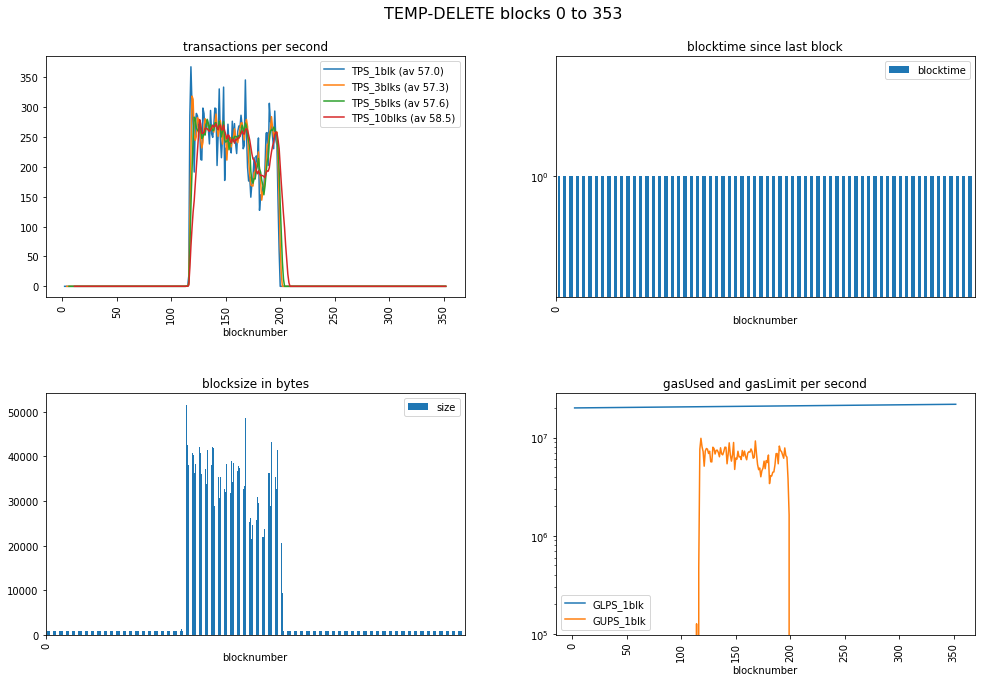

In [ ]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, NAME_PREFIX, gas_logy=True, bt_logy=True)

<a id='zoom1'>zoom in on one experiment</a>

# zooming in ...


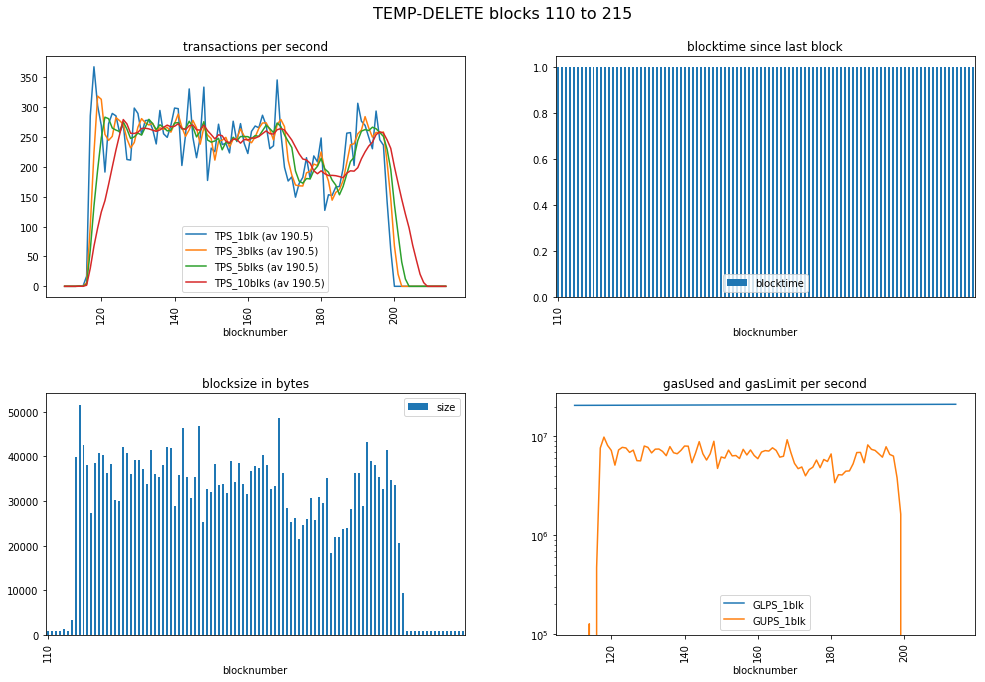

In [ ]:
# starting only at block xx because the waiting time before experiment start

diagrams(df, 110,215, NAME_PREFIX, gas_logy=True, bt_logy=False)